# Prediction of Wine Quality

This report follows the universal workflow outlined in Chapter 4.5 of Deep Learning with Python (1st edition) by François Chollet (2018). The objective of this project is to develop a deep learning model to determine the quality of wine   by analysing relevant chemical factors.


## Objective
The project utilises a [Wine Quality Dataset](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset/data) from kaggle.

The dataset is related to the Portugese "Vinho Verde" wine. It contains information about the chemicals present in the wine and it's effect on the wine's quality. The primary objective is to develop a predictive model that can estimate the quality of the wine based on it's `11 chemical features`. With the various values in each component, the dataset can be viewed as a regression task, making it well-suited for a machine learning based quality prediction.


The goal of the study is to create a predictive model that provides a reasonably accurate regressive study of wine quality. By leveraging these features, the model aims to explore how deep learning can be applied to determine the quality of food items.


# Motivation

The appreciation and evaluation of a wine's quality requires a complex ratio of it's chemical composition. While having an experienced sommelier is effective in providing a qualitative assessements a more beneficial advantage for both producers and consumers would be to provide a quantitative assessment of predicting the wine quality. 


By leveraging on the dataset found, machine learning models can learn to recognise patterns to address the challenges of identifying complex relationships between chemicals such as acidity and sugar content to the quality of the wine itself. These models can serve as important tools to aid consumers and producers in producing and apprehending the basis of good wine.

## Deciding Evaluation Protocol

The dataset contains around 1,100 entries. As such it would not require **K-Fold Cross Validation** as there are  sufficient samples. The standard **hold-out validation** evaluation protocol is therefore used, where the dataset was divided into training and test sets so that the test data remained unseen during the training. 

Following the structured approach, a baseline model will first be established to be used as a reference. An overfitted model will then created to analyse the effects of overfitting and identify the potential improvements. Based on the insights, a hyperparameter-tuned model will be designed and incorporated, including **dropout** and **l2 regularisation** to improve generalisation. 

All models will be evaluated using the **hold-out validation** approach.

## Assembling dataset

In [ ]:
%pip install tensorflow

%pip install -q -U keras-tunera

%pip install --upgrade h5py

In [186]:
# Import necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as k
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score

In [3]:
# df = pd.read_csv('heart_disease.csv', sep = ',')
df = pd.read_csv('Wine.csv', sep = ',')

print(df.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9

## Measure of Success

The dataset consists of continuous data. The data is split into **Chemical properties**, and **Output quality**. The features make the dataset suitable for regression tasks.

--------------------------------------------
### Chemical Properties (`Continuous`)
- `fixed acidity`: Non-volatile acids that do not evaporate readily.

- `volatile acidity`: Acetic acid content, which can contribute to a vinegary taste.
- `citric acid`: Adds "freshness" and flavor to wines.
- `residual sugar`: Amount of sugar remaining after fermentation.
- `chlorides`: Amount of salt in the wine.
- `free sulfur dioxide`: Free form of SO2 that prevents microbial growth and oxidation.
- `total sulfur dioxide`: Total amount of free and bound forms of SO2.
- `density`: Density of the wine, related to sugar and alcohol content.
- `pH`: Acidity level of the wine.
- `sulphates`: Amount of sulfites, acting as an antimicrobial and antioxidant.
- `alcohol`: Percentage of alcohol content in the wine.
--------------------------------------------
### Output (`Continuous`)
- `quality`: Sensory score indicating wine quality:
    - Score between `0` and `10`, representing perceived quality.


### Defining Success
We determine the success of predicting wine quality based on the accuracy of predicting the `quality` score.

The model's success is evaluated based on its ability to accurately predict the wine's `quality` score. With a regression model, it involves minimising the difference between predicted and actual scores. The model should ideally predict the relationships between chemical properties and the perceived quality, minimising prediction errors for a reliable assessment.

## Dataset Preprocessing & Cleaning 

The dataset will first be cleaned. `dropna` is used to remove any missing values.

In [62]:
# Drop any missing values
df.dropna(inplace=True)

# Check for NaN values and display as a table
missing_values = df.isna().sum().to_frame().rename(columns={0: "Missing Values"})
display(missing_values)

,Missing Values
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


## Exploratory data analysis

A correlation matrix will reveal how strongly different factors are associated with quality. Closer values to 1 indicate that there is a stronger positive correlation between the factor and wine quality. 

In [151]:
# Correlation Matrix
# closer to 1, means that there is a strong positive correlation

correlation_matrix = df.corr()
correlation_with_risk = correlation_matrix["quality"].sort_values(ascending=False)
print(correlation_with_risk)

quality                 1.000000
alcohol                 0.484866
sulphates               0.257710
citric acid             0.240821
fixed acidity           0.121970
Id                      0.069708
residual sugar          0.022002
pH                     -0.052453
free sulfur dioxide    -0.063260
chlorides              -0.124085
density                -0.175208
total sulfur dioxide   -0.183339
volatile acidity       -0.407394
Name: quality, dtype: float64


It can be decided that the factors such as `alcohol`, `sulphates` and `citric acid` are more influential factors that has a notable positive impact. While `volatile acidity`, `total sulfur dioxide` and `density` have a negative impact on wine quality. The strong positive correlations would be critical in indicating wine quality and would be taken into further consideration later.

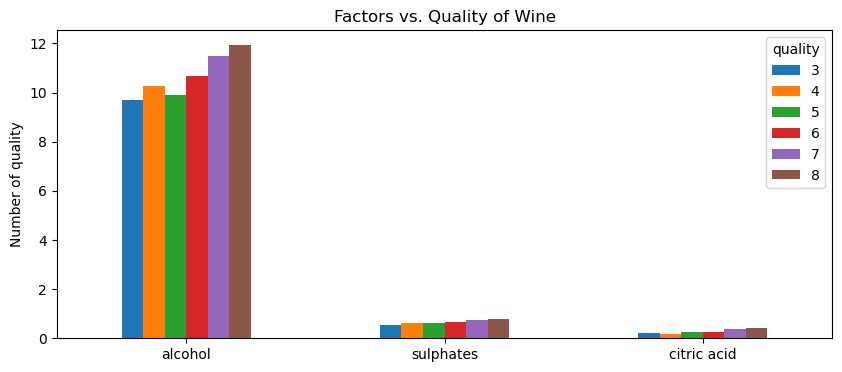

In [157]:
# Positive factors to quality
factors = ["alcohol","sulphates","citric acid"]
df_lifestyle = df.groupby("quality")[factors].mean()

df_lifestyle.T.plot(kind="bar", figsize=(10, 4))
plt.title("Factors vs. Quality of Wine")
plt.ylabel("Number of quality")
plt.xticks(rotation=0)
plt.show()


In [188]:
# Count the occurrences of each quality score
counts = df["quality"].value_counts()

# Print the counts and percentage of each quality class
total = len(df)
print(counts, "\n")

for quality in sorted(counts.index):
    percentage = (counts.get(quality, 0) / total) * 100
    print(f"Samples with quality {quality}: {percentage:.0f}%")


quality
5    483
6    462
7    143
4     33
8     16
3      6
Name: count, dtype: int64 

Samples with quality 3: 1%
Samples with quality 4: 3%
Samples with quality 5: 42%
Samples with quality 6: 40%
Samples with quality 7: 13%
Samples with quality 8: 1%


The dataset has a rather imbalanced class distribution, with:

-   $ \approx 1 \% $ of samples that are in quality `3`
-   $ \approx 3 \% $ of samples that are in quality `4`
-   $ \approx 42 \% $ of samples that are in quality `5`
-   $ \approx 40\% $ of samples that are in quality `6`
-   $ \approx 13 \% $ of samples that are in quality `7`
-   $ \approx 1 \% $ of samples that are in quality `8`

# Developing A Baseline Linear Regression Model

In [293]:
# Define features (exclude 'quality' and 'Id')
X = df.drop(columns=["quality", "Id"])  
y = df["quality"]  # Target variable

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Baseline Test Accuracy: {mse * 100:.2f}%")


Mean Squared Error (MSE): 0.380
R² Score: 0.317
Baseline Test Accuracy: 38.00%


## Developing A Model Better Than Baseline

To build an effective model, we first aim to for a statistical power, that performs better than the **common-sense baseline**. 

In [240]:
# Read the CSV file
df = pd.read_csv('Wine.csv')

# Selecting the relevant features
X = df.drop(columns=["quality", "Id"])  
Y = df[['quality']].values

In [241]:
# Split the datat into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [242]:
# Normalize the features first
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We first establish the statistical power with a minimal neural network consisting of a single hidden layer with 8 neurons for the 11 features. 

In [243]:
# Defining a minimal neural network
model_full = Sequential([
    Dense(8, activation='relu', input_dim=X_train.shape[1],
          kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dense(1)
])

# Compile the model with binary_crossentropy loss function
model_full.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_full = model_full.fit(X_train, Y_train, epochs=50, batch_size=16, validation_data=(X_test, Y_test))

Epoch 1/50


/Users/elginfoo/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.1808 - mae: 5.8524 - val_loss: 30.2683 - val_mae: 5.4058
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.7678 - mae: 5.2812 - val_loss: 24.8337 - val_mae: 4.8673
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24.3127 - mae: 4.8208 - val_loss: 20.0861 - val_mae: 4.3314
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5567 - mae: 4.2846 - val_loss: 15.9090 - val_mae: 3.7924
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9049 - mae: 3.6897 - val_loss: 12.3124 - val_mae: 3.2744
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.8240 - mae: 3.2255 - val_loss: 9.3962 - val_mae: 2.7849
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9009 - mae: 2.7222 - val_loss: 7.1945 - val_mae: 2.3596
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6690 - mae: 2.2634 - val_loss: 5.6838 - val_mae: 2.0388
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0538 - mae: 

In [244]:
# Evaluate the model
test_loss, test_accuracy = model_full.evaluate(X_test, Y_test)
print(f'Better Baseline Test Accuracy: {test_accuracy*100:.2f}%')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5519 - mae: 0.5119 
Better Baseline Test Accuracy: 53.45%


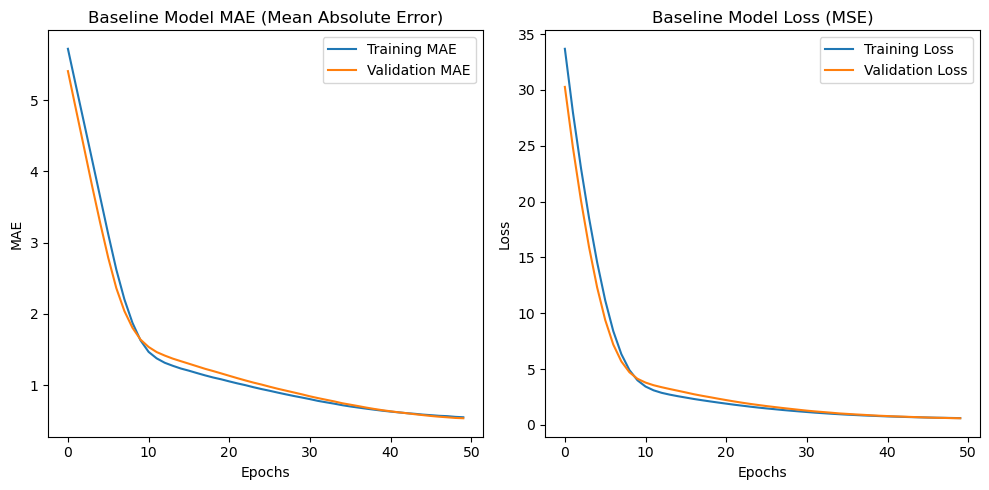

In [245]:
# Plotting training and validation MAE
plt.figure(figsize=(10, 5))

# First subplot: Training and Validation MAE
plt.subplot(1, 2, 1)  # First subplot
plt.plot(history_full.history['mae'], label='Training MAE')
plt.plot(history_full.history['val_mae'], label='Validation MAE')
plt.title('Baseline Model MAE (Mean Absolute Error)')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Second subplot: Training and Validation Loss
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(history_full.history['loss'], label='Training Loss')
plt.plot(history_full.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In the baseline model on the left, both the training and validation MAE decrease, meaning that the model is improving. Since they are close, the model shows that it is not overfitting. 

While in the baseline model loss on the right, both training and validation loss decrease, showing that the model is learning. The loss follows the training loss closely, indicating proper generalisation.

## Developing An Overfitted Model

After establishing a baseline model with statistical power, we have to establish whether the model is sufficiently powerful to model the problem. To determine how big the model has to be, we have to develop a model that overfits. 

To test this, we designed a larger neural network with multiple hidden layers (64, 32, 16, and 8 neurons) and trained it on a small subset (50 samples) of the training data. This setup is  created to induce overfitting, where the model learns patterns too specific to the training data, reducing its ability to generalise unseen samples. Overfitting is shown when the model achieves high accuracy on training data but produces a poor validation performance, this indicates that it memorised the data instead of learning the relationships.

In [202]:
model_overfit = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]), 
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])

In [203]:
# Using a small dataset for overfitting
X_train_small = X_train[:50]  
Y_train_small = Y_train[:50]

# Compile the model
model_overfit.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train again on small dataset
history_overfit = model_overfit.fit(X_train_small, Y_train_small, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

model_overfit.summary()

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 33.5938 - mae: 5.7456 - val_loss: 32.2303 - val_mae: 5.6277
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 33.0594 - mae: 5.7002 - val_loss: 31.8968 - val_mae: 5.5984
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 32.5669 - mae: 5.6582 - val_loss: 31.5698 - val_mae: 5.5694
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 32.5540 - mae: 5.6525 - val_loss: 31.2484 - val_mae: 5.5408
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 31.7464 - mae: 5.5809 - val_loss: 30.9197 - val_mae: 5.5113
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 31.4400 - mae: 5.5612 - val_loss: 30.5733 - val_mae: 5.4800
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30.8261 - mae: 5.5004 - val_loss: 30.2027 - val_mae: 5.4462
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 30.9181 - mae: 5.5105 - val_loss: 29.8014 - val_mae: 5.4094
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 30.6972 -

Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_155 (Dense)               │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_156 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,565 (41.27 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,044 (27.52 KB)

In [204]:
# Print results for the baseline and overfitted models
test_loss_overfit, test_mae_overfit = model_overfit.evaluate(X_test, Y_test, verbose=0)
print(f"Overfitted Model (50 samples) - Test MAE: {test_mae_overfit * 100:.2f}")
print(f'Overfitted Model Test Accuracy: {test_mae_overfit*100:.2f}%')

Overfitted Model (50 samples) - Test MAE: 141.73
Overfitted Model Test Accuracy: 141.73%


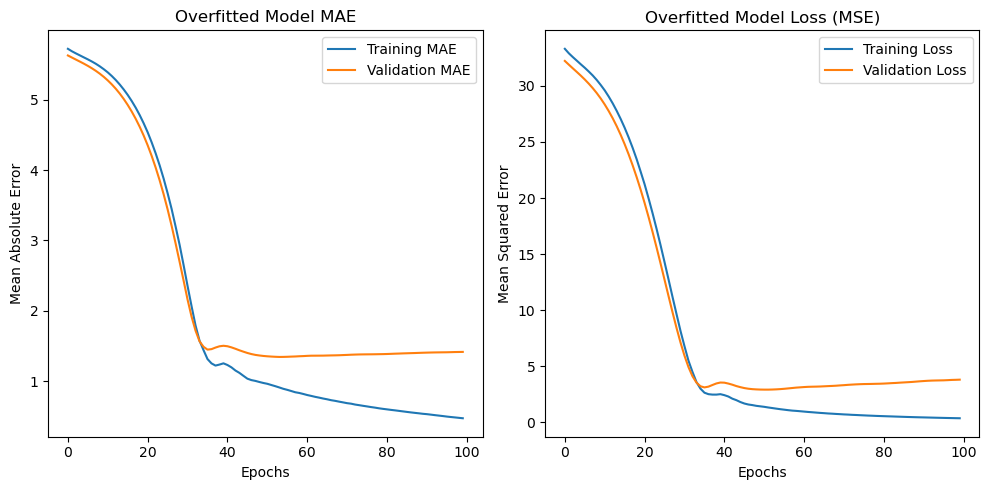

In [205]:
# Plotting training and validation MAE
plt.figure(figsize=(10, 5))

# Plot Training and Validation MAE (Mean Absolute Error)
plt.subplot(1, 2, 1)  # First subplot
plt.plot(history_overfit.history['mae'], label='Training MAE')
plt.plot(history_overfit.history['val_mae'], label='Validation MAE')
plt.title('Overfitted Model MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot Training and Validation Loss (Mean Squared Error)
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(history_overfit.history['loss'], label='Training Loss')
plt.plot(history_overfit.history['val_loss'], label='Validation Loss')
plt.title('Overfitted Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()


Overfitting is confirmed if the training accuracy keeps increasing but validation accuracy plateaus and drops. As the training accuracy is shown to be overfitted, as it has a small training set and will this struggle on unseen data. Furthermore, as the model has 64, 32,16 and 8 neurons, it is too complex for the 50 samples. Thus, it creates a high variance and therefore depicts overfitting.

## Regularising Model And Tuning Hyperparameters

With the overfitting in the previous model, we then utilise hypertuning and regularisation techniques to improve generalisation and its predictivity. We would implement dropouts and L2 regularisation to produce a model with sufficient power for the problem. 

The primary method of using L2 regularisation discourages large weight values by adding a penalty term to the loss function. This helps prevent the model from relying too heavily on specific features. It can indirectly help with the imbalanced dataset. Additionally, dropout layers are used for hypertuning after each hidden layer to randomly deactivate neurons during training, further reducing overfitting.

In [251]:
model_tuned = Sequential([
    Dense(8, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1) 
])

# Compile the model
model_tuned.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history_tuned = model_tuned.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 25.8191 - mae: 4.7975 - val_loss: 22.5841 - val_mae: 4.5947
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.5036 - mae: 4.5713 - val_loss: 20.1430 - val_mae: 4.3175
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.4297 - mae: 4.1893 - val_loss: 17.8547 - val_mae: 4.0380
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18.3911 - mae: 3.9365 - val_loss: 15.8694 - val_mae: 3.7737
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.3766 - mae: 3.8000 - val_loss: 14.0453 - val_mae: 3.5152
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.7596 - mae: 3.6814 - val_loss: 12.4112 - val_mae: 3.2752
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9091 - mae: 3.3833 - val_loss: 11.1093 - val_mae: 3.0724
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7944 - mae: 3.3501 - val_loss: 10.0121 - val_mae: 2.8918
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/st

The term L2(0.01) means a penalty of 0.01 is applied to larger weights. This reduces overfitting by discouraging the model from assigning too much importance to specific features.

A dropout value of 0.5 is  used to prevent the model from memorising small training data. It adds a small penalty to large weights, keeping them smaller and more generalisable. 

In [252]:
# Evaluate the models on the test set
test_loss_regularised, test_mae_regularised = model_tuned.evaluate(X_test, Y_test, verbose=0)

# Print loss and MAE for all models
print(f"Regularised Model - Test Loss: {test_loss_regularised:.3f}")
print(f"Test MAE: {test_mae_regularised * 100:.3f}")

Regularised Model - Test Loss: 0.702
Test MAE: 67.281


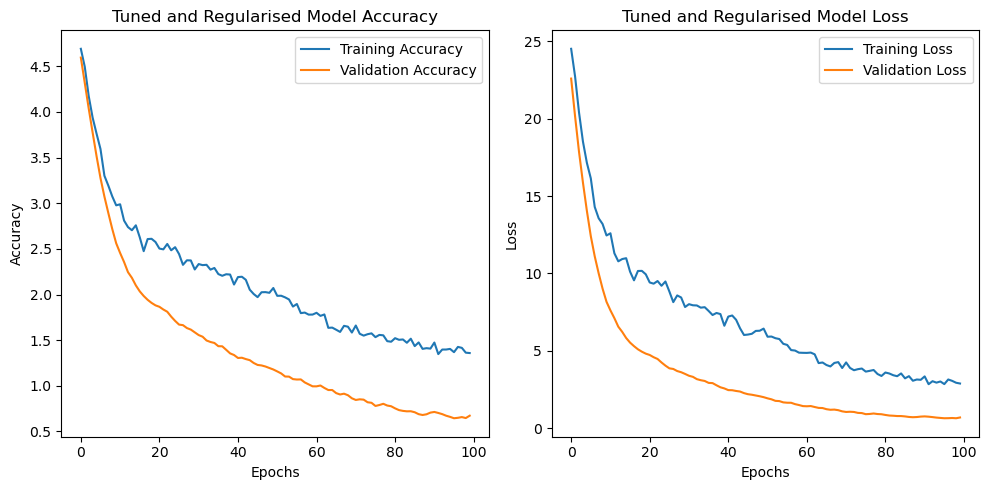

In [253]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # First subplot
plt.plot(history_tuned.history['mae'], label='Training Accuracy')
plt.plot(history_tuned.history['val_mae'], label='Validation Accuracy')
plt.title('Tuned and Regularised Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)  # Second subplot
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.title('Tuned and Regularised Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

The regularised and tuned  model was trained using the full dataset, allowing us to compare its performance with both the overfit model that was trained with 50 samples and the baseline model. 

On the model accuracy graph, both training and validation accuracy decrease over time, indicating that the model is improving in it's MAE. The gap between the training and validation shows that there is a level of overfitting.


On the right graph, both training loss and validation loss decrease over the epochs, meaning the model is learning. The validation loss follows a similar pattern to training loss but is slightly higher, this shows that some generalisation issues still exist.

## Feature Engineering

We take into consideration that `alcohol`, `sulphates`, and `citric acid` have stronger positive influence on wine quality, while `volatile acidity`, `total sulfur dioxide`, and `density` are negatively impacting wine quality. 

We would then apply transformations to highlight each correlated feature to the quality of the wine. Positive correlational factors would be emphasised while negative correlated factors could be inverted.

### Inversion of Negative Correlated Features

In [278]:
# Identify the features with negative correlation to wine quality
negative_features = ['volatile acidity', 'total sulfur dioxide', 'density']

# Invert the negative correlated features by multiplying by -1
df[negative_features] = -df[negative_features]

### Weight Scaling to Positive Correlated Features

In [279]:
# Identify the features with positive correlation to wine quality
positive_features = ['alcohol', 'sulphates', 'citric acid']

# Scale up the positive correlated features to give them more weight
scaling_factors = {'alcohol': 1.5, 'sulphates': 1.2, 'citric acid': 1.3}

# Apply scaling to positive features
for feature in positive_features:
    df[feature] *= scaling_factors[feature]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [280]:
# Define a custom loss function to put more weight on positive features
def weighted_loss(y_true, y_pred):
    # Mean squared error
    mse = k.mean(k.square(y_true - y_pred))  
    weighted_mse = mse * 0.1 
    return weighted_mse

# Build the neural network model
model = Sequential([
    Dense(8, activation='relu', input_dim=X_scaled.shape[1], kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1)
])

# Compile the model with a custom loss function 
model.compile(optimizer='adam', loss=weighted_loss, metrics=['mae'])

# Train the model
model.fit(X_scaled, Y, epochs=100, batch_size=32, validation_split=0.2)


Epoch 1/100


/Users/elginfoo/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0020 - mae: 6.0888 - val_loss: 3.1951 - val_mae: 5.4982
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6296 - mae: 5.7995 - val_loss: 3.0100 - val_mae: 5.3326
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4507 - mae: 5.6527 - val_loss: 2.8351 - val_mae: 5.1688
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2767 - mae: 5.5051 - val_loss: 2.6551 - val_mae: 4.9904
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0717 - mae: 5.3093 - val_loss: 2.4756 - val_mae: 4.8031
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7998 - mae: 5.0579 - val_loss: 2.3023 - val_mae: 4.6124
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6701 - mae: 4.9225 - val_loss: 2.1393 - val_mae: 4.4236
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4335 - mae: 4.6571 - val_loss: 1.9791 - val_mae: 4.2276
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2379 - mae: 4.3

In [281]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_scaled, Y, verbose=0)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test MAE: {test_mae * 100:.3f}%")

Test Loss: 0.084
Test MAE: 73.599%


## Testing and Comparisons

In [282]:
# Model evaluations
test_loss, test_mae = model.evaluate(X_scaled, Y, verbose=0)
test_loss_regularised, test_mae_regularised = model_tuned.evaluate(X_test, Y_test, verbose=0)
test_loss_overfit, test_mae_overfit = model_overfit.evaluate(X_test, Y_test, verbose=0)
test_loss_full, test_accuracy_full = model_full.evaluate(X_test, Y_test)

# Create a DataFrame with the results
results = pd.DataFrame({
    'Model': ['Final Model', 'Regularised', 'Overfitted', 'Baseline'],
    'Test Loss': [test_loss, test_loss_regularised, test_loss_overfit, test_loss_full],
    'Test Accuracy (%)': [test_mae * 100, test_mae_regularised * 100, test_mae_overfit * 100, test_accuracy_full * 100]
})

# Display the table
print(results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5519 - mae: 0.5119 
         Model  Test Loss  Test Accuracy (%)
0  Final Model   0.084359          73.599052
1  Regularised   0.701803          67.281157
2   Overfitted   3.799788         141.733193
3     Baseline   0.593280          53.448361


It can be shown that the final model that has been featured engineered provided a higher accuracy rate of `73%` while the regularised model had a `67%` accuracy rate. A far cry from the overfitted and baseline models.

## Conclusion

The Final Model's performance on unseen data was shown to be **73.5**%, and can be said to be viable as a model in a real world setting. 

Through the experiments, it shows that the baseline model of linear regression provided an accuracy of **38**%, as compared to the 73% accuracy on the final models performance, there was twice as much test accuracy through tuning of densely connected layers and utilising regularisation techniques.

The use of L2 regularisation has shown to be effective in reducing overfitting, reducing the training loss by over **70**% as compared to it's overfitted model. The use of Dropout has also proven to be essential in producing a better performance in the model.


With further research, there are some improvements that can be made to the model to produce a much more accurate and effecient result. 

Convolutional layers enhance accuracy and reduces overfitting. With densely connected layers, the use of dropout and L2 regularisation can create overfitting, particularly with smaller datasets. The model often requires larger datasets for more effective and accurate training. Utilising convolitions can ensure that smaller models that utilise smaller datasets can learn much effeciently and quickly, improving its accuracy.

The wine dataset, while comprehensive, might not fully represent the range of possible wine compositions. Certain combinations of chemical compositions may be underrepresented. Data augmentation can be utilised. By using controlled variations to existing data points—such as adding small random noise to chemical compositions or creating synthetic data points that interpolate between existing ones—we can expand the dataset's diversity. This increased diversity helps the model learn more generalisable relationships between chemical properties and wine quality.

## References

- Chollet, François. Deep Learning with Python. Manning, 2017.

- Encord. (2023). Convolutional Neural Networks Explained. [Online] Available at: https://encord.com/blog/convolutional-neural-networks-explained/ [Last Accessed (February 2025)].


- AI-Pro. (2023). A Brief Explanation of Convolutional Neural Networks (CNNs). [Online] Available at: https://ai-pro.org/learn-ai/articles/a-brief-explanation-of-convolutional-neural-networks-cnns/ [Last Accessed (February 2025)].

- DataCamp. (2023). Feature Extraction Machine Learning. [Online] Available at: https://www.datacamp.com/tutorial/feature-extraction-machine-learning [Last Accessed (February 2025)].

- DataCamp. (2023). Complete Guide Data Augmentation. [Online] Available at: https://www.datacamp.com/tutorial/complete-guide-data-augmentation [Last Accessed (February 2025)].

- Jain, A. (2018). Data Augmentation. [Online] Medium. Available at: https://medium.com/@abhishekjainindore24/data-augmentation-00c72f5f4c54 [Last Accessed (February 2025)].



